Feature Engineering and Model Training

Going to make use a recurrent neurel network called LSTM (Long short term memory) for modelling stock price data as the data is sequential. As stock price data is sequential, where each data point depends on the previous ones. RNNs are designed to capture temporal dependencies, making them well-suited for modeling and predicting time series data.

Going to use the stock market prediction using LSTM recurrent neural network paper by Adil Moghar and Mhamed Hamiche as reference (https://www.sciencedirect.com/science/article/pii/S1877050920304865) to make my own model.

In [166]:
# Data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from datetime import datetime

# Data processing
from sklearn.preprocessing import MinMaxScaler

# Model and measure metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense

Going to create a model for the google stock price dataset

In [167]:
traindf = pd.read_csv('../datasets/GOOG.csv')

testdf = pd.read_csv('../datasets/GOOG_Test.csv')

In [168]:
traindf.Date = pd.to_datetime(traindf['Date'])
traindf = traindf.set_index('Date')

testdf.Date = pd.to_datetime(testdf['Date'])
testdf = testdf.set_index('Date')

In [169]:
traindf = traindf.drop(['Close'], axis='columns')
traindf = traindf.rename(columns={'Adj Close': 'Close'})

In [170]:
train_dates = traindf.index
test_dates = testdf.index

In [171]:
class LogAndSquareScaler:
    
    def fit_transform(self,data):
        scaled = np.log(data)
        scaled = np.sqrt(scaled)
        return scaled
    
    def transform(self,data):
        scaled = np.log(data)
        scaled = np.sqrt(scaled)
        return scaled    
    def inverse_transform(self, data):
        inverse = np.square(data)
        inverse = np.exp(inverse)
        return inverse

In [172]:
train = np.array(traindf.Close)
test = np.array(testdf.Close)

train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [173]:
sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)
test_scaled = sc.transform(test)

In [174]:
train_scaled

array([[0.00000000e+00],
       [3.41124932e-04],
       [3.53674976e-03],
       ...,
       [4.23268878e-01],
       [4.45620344e-01],
       [4.43645568e-01]])

In [175]:
len(train), len(test)

(1510, 251)

Need to convert the data into supervised format for neural network. So data needs to be in (x,y) format where x are the features and y is the target. As time series data is sequential the features x are the number of previous days prices we use to predict next days price.

Going to use past 32 days as features as look back so, x(t-32), x(t-31), ... , x(t-1) will give x(t) which is y(t) 

In [176]:
look_back = 32

In [177]:
def preprocess_data(dataset,step):
    X = []
    Y = []
    for i in range(step, len(dataset)):
        X.append(dataset[i-step:i, 0])
        Y.append(dataset[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

In [178]:
X_train, y_train = preprocess_data(train_scaled,look_back)
X_test, y_test = preprocess_data(test_scaled, look_back)

In [179]:
model = Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=100))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
impl = model.fit(
    X_train,
    y_train,
    validation_split=0.33,
    epochs=100,
    batch_size=60
    )

Epoch 1/100
17/17 [==============================] - 6s 170ms/step - loss: 0.0082 - val_loss: 0.0306
Epoch 2/100
17/17 [==============================] - 1s 57ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 3/100
17/17 [==============================] - 1s 58ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 4/100
17/17 [==============================] - 1s 56ms/step - loss: 9.4772e-04 - val_loss: 0.0033
Epoch 5/100
17/17 [==============================] - 1s 55ms/step - loss: 9.5345e-04 - val_loss: 0.0032
Epoch 6/100
17/17 [==============================] - 1s 55ms/step - loss: 9.0136e-04 - val_loss: 0.0032
Epoch 7/100
17/17 [==============================] - 1s 54ms/step - loss: 7.8852e-04 - val_loss: 0.0027
Epoch 8/100
17/17 [==============================] - 1s 58ms/step - loss: 8.2960e-04 - val_loss: 0.0025
Epoch 9/100
17/17 [==============================] - 1s 55ms/step - loss: 7.6157e-04 - val_loss: 0.0024
Epoch 10/100
17/17 [==============================] - 1s 55ms/step - loss: 

In [180]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 32, 100)           40800     
                                                                 
 dropout_28 (Dropout)        (None, 32, 100)           0         
                                                                 
 lstm_29 (LSTM)              (None, 32, 100)           80400     
                                                                 
 dropout_29 (Dropout)        (None, 32, 100)           0         
                                                                 
 lstm_30 (LSTM)              (None, 32, 100)           80400     
                                                                 
 dropout_30 (Dropout)        (None, 32, 100)           0         
                                                                 
 lstm_31 (LSTM)              (None, 100)              

Plot the training and validation loss to make sure overfitting does not occur and data is only trained on general principles.

Can see validation loss never trends up, so model is never trained too close to the training set.

In [181]:
impl.history.keys()

dict_keys(['loss', 'val_loss'])

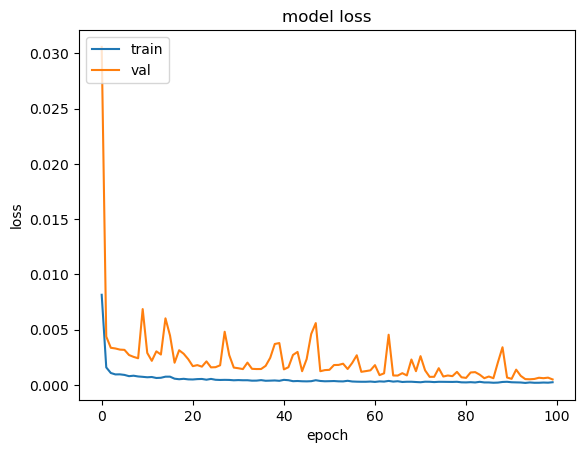

In [182]:
plt.plot(impl.history['loss'])
plt.plot(impl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [183]:
np.array(train[len(train)-look_back:]).shape

(32, 1)

In [184]:
np.array(test).shape

(251, 1)

In [185]:
predictions_scaled = model.predict(X_test)
predictions = sc.inverse_transform(predictions_scaled)

train = pd.DataFrame(train, index=train_dates)
test = pd.DataFrame(test, index=test_dates)
predictions = pd.DataFrame(predictions, index=test_dates[look_back:])

rmse = np.sqrt(np.mean(((predictions - test[look_back:]) ** 2)))
rmse


7/7 [==============================] - 1s 11ms/step


2.4669141076232095

Looks good but really only proves it can guess the next day well. Each sequence in X_test is the previous look_back number of days. If we want the model to guess further into the future we would have to use the models own previous predictions as if they were the real days. Or possibly a better alternative to predict further into the future would be a multi-step lstm. In a multistep lstm the X data would look like X = [x1, x2, ... , xlookback] and the Y data, Y = [y1, y2, ... , ypredictnum], where predictnum is the number of days we want to predict.

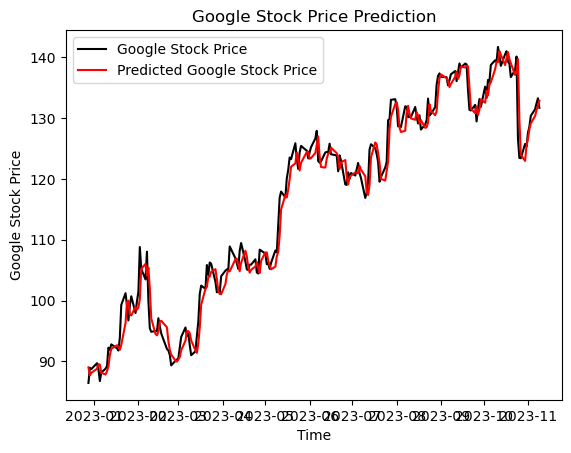

In [186]:
figure, axes = plt.subplots( 1 ) 

axes.plot(test[look_back:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

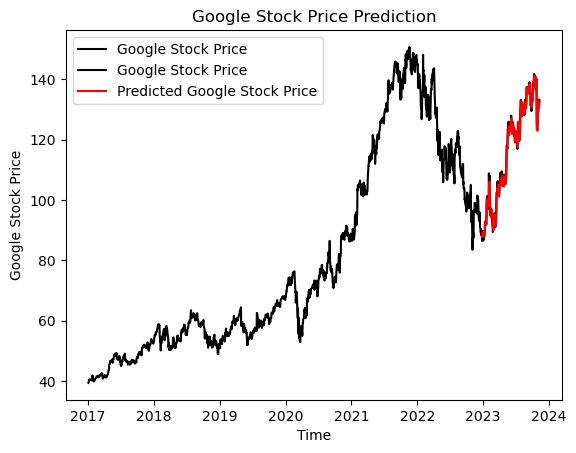

In [187]:
figure, axes = plt.subplots( 1 ) 

axes.plot(train, color = 'black', label = 'Google Stock Price')
axes.plot(test[look_back:], color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

In [188]:
predictions

,0
Date,
2022-12-28,89.022476
2022-12-29,87.695663
2022-12-30,88.121727
2023-01-03,88.779388
2023-01-04,89.568687
...,...
2023-11-03,129.128555
2023-11-06,130.343384
2023-11-07,131.273590


In [189]:
X_test

array([[[0.49247768],
        [0.51545756],
        [0.50917398],
        ...,
        [0.4394266 ],
        [0.45334014],
        [0.43646434]],

       [[0.51545756],
        [0.50917398],
        [0.53332078],
        ...,
        [0.45334014],
        [0.43646434],
        [0.42326888]],

       [[0.50917398],
        [0.53332078],
        [0.53574441],
        ...,
        [0.43646434],
        [0.42326888],
        [0.44562034]],

       ...,

       [[0.8253263 ],
        [0.83358466],
        [0.80916857],
        ...,
        [0.80135906],
        [0.81742693],
        [0.82712157]],

       [[0.83358466],
        [0.80916857],
        [0.82721143],
        ...,
        [0.81742693],
        [0.82712157],
        [0.83564922]],

       [[0.80916857],
        [0.82721143],
        [0.84220216],
        ...,
        [0.82712157],
        [0.83564922],
        [0.84336902]]])

Predicting multiple days based on previous predictions:

In [190]:
test_lookback = X_test[0:1]
for i in range(0,250):
    test_lookback = np.append(test_lookback,model.predict(test_lookback))
    test_lookback = np.reshape(test_lookback, (1,len(test_lookback),1))
    print(model.predict(test_lookback))


1/1 [==============================] - 1s 661ms/step
[[0.44644123]]
1/1 [==============================] - 0s 13ms/step
[[0.44854695]]
1/1 [==============================] - 0s 13ms/step
[[0.45105758]]
1/1 [==============================] - 0s 13ms/step
[[0.45363474]]
1/1 [==============================] - 0s 13ms/step
[[0.45620674]]
1/1 [==============================] - 0s 12ms/step
[[0.4587528]]
1/1 [==============================] - 0s 13ms/step
[[0.46127293]]
1/1 [==============================] - 0s 13ms/step
[[0.46377495]]
1/1 [==============================] - 0s 13ms/step
[[0.4662637]]
1/1 [==============================] - 0s 13ms/step
[[0.46873426]]
1/1 [==============================] - 0s 13ms/step
[[0.47117078]]
1/1 [==============================] - 0s 13ms/step
[[0.4735487]]
1/1 [==============================] - 0s 13ms/step
[[0.47583947]]
1/1 [==============================] - 0s 13ms/step
[[0.47801572]]
1/1 [==============================] - 0s 13ms/step
[[0.48005423

In [191]:
test_lookback

array([[[0.49247768],
        [0.51545756],
        [0.50917398],
        [0.53332078],
        [0.53574441],
        [0.53134594],
        [0.52506242],
        [0.5073787 ],
        [0.52084345],
        [0.53421842],
        [0.52326707],
        [0.51114882],
        [0.50387787],
        [0.55782659],
        [0.5563006 ],
        [0.5522612 ],
        [0.54364377],
        [0.52066389],
        [0.50127469],
        [0.49050284],
        [0.48260355],
        [0.48700202],
        [0.5075582 ],
        [0.50271089],
        [0.46581747],
        [0.46276549],
        [0.44741569],
        [0.45172436],
        [0.45728982],
        [0.4394266 ],
        [0.45334014],
        [0.43646434],
        [0.44627091],
        [0.44644123],
        [0.44854695],
        [0.45105758],
        [0.45363474],
        [0.45620674],
        [0.45875281],
        [0.46127293],
        [0.46377495],
        [0.46626371],
        [0.46873426],
        [0.47117078],
        [0.47354871],
        [0

In [192]:
test_lookback = sc.inverse_transform(test_lookback[0])
test_lookback = test_lookback.reshape(-1) 
test_lookback = pd.DataFrame(test_lookback[look_back-1:], index=test_dates)

In [193]:
test_lookback

,0
Date,
2022-11-10,87.930000
2022-11-11,89.022472
2022-11-14,89.041446
2022-11-15,89.276026
2022-11-16,89.555716
...,...
2023-11-03,133.515624
2023-11-06,133.827681
2023-11-07,134.141670


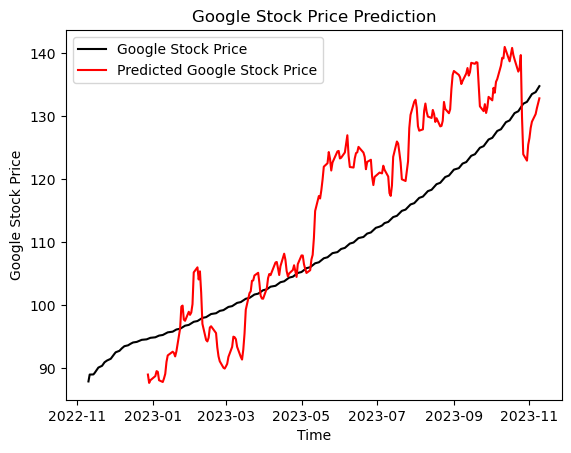

In [194]:
figure, axes = plt.subplots( 1 ) 

axes.plot(test_lookback, color = 'black', label = 'Google Stock Price')
axes.plot(predictions, color = 'red', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')

plt.legend()
plt.show()

Multistep LSTM